In [3]:
%matplotlib inline

In [4]:
!pip install -r requirements.txt

In [29]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from catboost import CatBoostRegressor, Pool, cv as catboost_cv
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, LeaveOneOut, LeavePOut, cross_validate, KFold)

# --- Import scikit-learn metrics directly ---
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

from sklearn.feature_selection import RFECV

from scipy.stats import randint, uniform
import optuna # Added import
from imblearn.over_sampling import RandomOverSampler # Added import

# Import necessary functions from utils.py (excluding metrics)
from utils import (
    plot_pred_vs_actual_plotly,
    plot_shap_summary,
    plot_shap_waterfall,
    plot_shap_dependence,
    plot_native_feature_importance # Keep native importance plot
    # Removed RMSE, MAPE, calculate_r2 from utils import
)

In [6]:
# graphique feature selection (celui de catboost)
# les tree based modèles n'ont pas de pb de colinéarité
# par contre si les variables sont corrélés, les feature importance plot n'indiquent pas les vraies valeurs
# du coup on fait les shap values
# catboost feature selection plot

In [7]:
DATA_PATH = "data/conso_data.csv"
TARGET_COLUMN = "pitd"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Tuning settings
N_ITER_RANDOM_SEARCH = 65 # Iterations for RandomizedSearchCV
N_TRIALS_OPTUNA = 100      
CV_FOLDS_TUNING = 5       
# File to save/load best parameters
PARAMS_FILENAME = 'best_catboost_params.json'

# Oversampling settings
HOLIDAY_COLUMN = 'is_holiday' # *** IMPORTANT: ASSUMING this column exists or will be created ***
ENABLE_OVERSAMPLING = False

GRID_SEARCH_POINTS = 3 # Number of points per continuous parameter in Grid Search (e.g., 3 = low, center, high)
GRID_SEARCH_RANGE_FACTOR = 0.15 

In [8]:
df = pd.read_csv("data/conso_data.csv")
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'] - pd.Timedelta(hours=6)
df.drop(columns = ['pitd1','pitd2','pitd7','target', 'target1', 'target2', 'pitd_terega', 'target7'], inplace = True)

In [9]:
# Calculate Heating Degree Days (HDD)
base_temp = 16.5
df['tmoy'] = pd.to_numeric(df['tmoy'], errors='coerce')
df['hdd'] = (base_temp - df['tmoy']).clip(lower=0)
df['rolling_hdd_7'] = df['hdd'].rolling(7, min_periods=1).sum()

In [10]:
for l in [1, 2, 3, 7, 14]:
    df[f'pitd_lag{l}'] = df['pitd'].shift(l)
    df[f'hdd_lag{l}']  = df['hdd'].shift(l)
    df[f'tmoy_lag{l}'] = df['tmoy'].shift(l)

df['lag1_to_lag7_ratio']= df['pitd_lag1'] / df['pitd_lag7']

for w in [3, 7, 14]:
    df[f'pitd_ma_{w}']  = df['pitd'].shift(1).rolling(w, min_periods=1).mean()
    df[f'pitd_ewm_{w}'] = df['pitd'].shift(1).ewm(span=w, adjust=False).mean()
    df[f'pitd_std_{w}'] = df['pitd'].shift(1).rolling(w, min_periods=1).std()


df['is_winter'] = (df['season_metero'].str.lower() == 'winter').astype(int)
df['weekend_winter'] = df['weekend'] * df['is_winter']
df['weekend_cold'] = df['weekend'] * df['hdd']

df.bfill(inplace=True)

In [11]:
df['date'] = pd.to_datetime(df['date']) + pd.Timedelta(hours=6) # gaz date

df = df.dropna(subset=['pitd_lag1']).reset_index(drop=True)

In [12]:
df['perceived_temp'] = 0.7*df['tmoy'] + 0.3*df['teff_cwv']
df['heating_on'] = (df['perceived_temp'] < 16.5).astype(int) 

holidays = df.loc[df['isHoliday']==True, 'date']
nearest_hday = pd.to_datetime(df['date']).apply(
    lambda d: (abs(holidays - d)).min().days if not holidays.empty else np.nan
)
df['days_to_holiday'] = nearest_hday

df['hdd_bizday'] = df['hdd'] * df['isBizday']

df.bfill(inplace=True)

In [13]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [14]:
X = df.drop(columns=["pitd"]) #target
y = df['pitd']

In [15]:
num_variables = X.columns[X.dtypes == 'float64'].tolist()
cat_variables = X.columns[X.dtypes == 'category'].tolist()

In [16]:
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
datetime_cols = X_train_sel.select_dtypes(
    include=['datetime64[ns]', 'datetimetz']
).columns
print("Dropping datetime cols for FS:", datetime_cols)

Xfs_train = X_train_sel.drop(columns=datetime_cols)
Xfs_test  = X_test_sel.drop(columns=datetime_cols)

cat_feats_fs = Xfs_train.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_feats_fs:
    Xfs_train[c] = Xfs_train[c].astype('category')
    Xfs_test [c] = Xfs_test [c].astype('category')
print("Categorical features for FS:", cat_feats_fs)
#selected_rfecv = ['li', 'li_terega', 'temp_mean', 'tmoy', 'teff_optim', 'teff_constr', 'teff_cwv', 'tmoy_diff_1', 'teff_constr_diff_1', 'teff_cwv_diff_1', 'year', 'isBizday', 'cosinus', 'wday', 'daydur', 'hdd', 'rolling_hdd_7', 'pitd_lag1', 'hdd_lag1', 'tmoy_lag1', 'pitd_lag2', 'hdd_lag3', 'pitd_lag7', 'hdd_lag7', 'pitd_lag14', 'pitd_ma_3', 'pitd_ewm_3', 'pitd_ma_7', 'pitd_ewm_7', 'pitd_ewm_14', 'day_of_year', 'cos_doy', 't_range', 'hdd_wind', 'perceived_temp', 'hdd_bizday']



Dropping datetime cols for FS: Index(['date'], dtype='object')
Categorical features for FS: ['below16.5_abc', 'type_vol', 'month', 'weekdays', 'season', 'season_astrono', 'season_metero', 'public_holidays', 'extended_holidays', 'dow', 'ponts_publics_abc', 'ponts_extended_abc']


In [17]:
# baseline catboost to sort by feature selection
baseline_cb = CatBoostRegressor(
    iterations=500, learning_rate=0.05, depth=6,
    random_seed=RANDOM_STATE,
    cat_features=cat_feats_fs, verbose=False
)
baseline_cb.fit(Xfs_train, y_train)
feat_imp = pd.Series(
    baseline_cb.get_feature_importance(), index=Xfs_train.columns
).sort_values(ascending=False)

# 50% best features
from sklearn.feature_selection import SelectFromModel
selector_sfm = SelectFromModel(baseline_cb, threshold='median', prefit=True)
selected_sfm = Xfs_train.columns[selector_sfm.get_support()].tolist()

# 3) RFECV — label-encode cats before feeding to sklearn
X_enc = Xfs_train.copy()
for c in cat_feats_fs:
    X_enc[c] = X_enc[c].cat.codes

rfecv = RFECV(
    estimator=CatBoostRegressor(
        iterations=200, learning_rate=0.1, depth=4,
        random_seed=RANDOM_STATE,
        cat_features=None,  # cats now numeric codes
        verbose=False
    ),
    step=1,
    cv=3,
    scoring=make_scorer(lambda yt, yp: -root_mean_squared_error(yt, yp)),
    n_jobs=-1
)
rfecv.fit(X_enc, y_train)

selected_rfecv = Xfs_train.columns[rfecv.support_].tolist() 

print("SFM kept:", selected_sfm)
print("RFECV kept:", selected_rfecv)

SFM kept: ['li', 'li_terega', 'temp_mean', 'tmoy', 'tmoy1', 'teff_optim', 'teff_constr', 'teff_cwv', 'tmoy_diff_1', 'teff_optim_diff_1', 'teff_constr_diff_1', 'teff_cwv_diff_1', 'year', 'cosinus', 'sinus', 'season', 'wday', 'hdd', 'rolling_hdd_7', 'pitd_lag1', 'hdd_lag1', 'tmoy_lag1', 'pitd_lag2', 'hdd_lag2', 'tmoy_lag2', 'pitd_lag3', 'hdd_lag3', 'tmoy_lag3', 'pitd_lag7', 'pitd_lag14', 'lag1_to_lag7_ratio', 'pitd_ma_3', 'pitd_ewm_3', 'pitd_ma_7', 'pitd_ewm_7', 'pitd_std_7', 'pitd_ma_14', 'pitd_ewm_14', 'pitd_std_14', 'perceived_temp', 'heating_on', 'hdd_bizday']
RFECV kept: ['li', 'temp_mean', 'tmoy', 'teff_optim', 'teff_constr', 'teff_cwv', 'teff_constr_diff_1', 'teff_cwv_diff_1', 'year', 'cosinus', 'sinus', 'doy', 'wday', 'hdd', 'rolling_hdd_7', 'pitd_lag1', 'hdd_lag1', 'pitd_lag2', 'pitd_lag14', 'pitd_ma_3', 'pitd_ewm_3', 'pitd_ma_7', 'pitd_ewm_7', 'perceived_temp', 'days_to_holiday', 'hdd_bizday']


In [18]:
X_rfecv    = Xfs_train[selected_rfecv]
cats_rfecv = [c for c in cat_feats_fs if c in selected_rfecv]
X_rfecv_test = Xfs_test[selected_rfecv]

In [31]:
train_pool = Pool(data=Xfs_train, label=y_train, cat_features=cat_feats_fs)
valid_pool = Pool(data=Xfs_test, label=y_test, cat_features=cat_feats_fs)
base_model = CatBoostRegressor(
    loss_function='MAPE',
    random_seed=RANDOM_STATE,
    verbose=False,
    cat_features = cat_feats_fs
)

In [ ]:
features = []
for i in range(30, Xfs_train.shape[1], 2): 
    fs_result = base_model.select_features(
        train_pool,
        eval_set=valid_pool,
        num_features_to_select=i,  
        algorithm='RecursiveByLossFunctionChange',
        features_for_select=Xfs_train.columns.tolist(), 
        steps=1,          
        plot=False,        
        verbose=True,
        train_final_model=False
    )

    selected_idx  = fs_result['selected_features']         
    selected_cols = [Xfs_train.columns[j] for j in selected_idx]

    features.append(selected_cols)

Step #1 out of 1
0:	learn: 0.5663366	test: 0.5695854	best: 0.5695854 (0)	total: 41ms	remaining: 41s
1:	learn: 0.5524934	test: 0.5550741	best: 0.5550741 (1)	total: 53.5ms	remaining: 26.7s
2:	learn: 0.5479705	test: 0.5503360	best: 0.5503360 (2)	total: 67.1ms	remaining: 22.3s
3:	learn: 0.5361308	test: 0.5388568	best: 0.5388568 (3)	total: 78.6ms	remaining: 19.6s
4:	learn: 0.5244608	test: 0.5270260	best: 0.5270260 (4)	total: 85.4ms	remaining: 17s
5:	learn: 0.5129591	test: 0.5157098	best: 0.5157098 (5)	total: 92.3ms	remaining: 15.3s
6:	learn: 0.5052023	test: 0.5080450	best: 0.5080450 (6)	total: 98.7ms	remaining: 14s
7:	learn: 0.4943750	test: 0.4968451	best: 0.4968451 (7)	total: 105ms	remaining: 13.1s
8:	learn: 0.4835820	test: 0.4861196	best: 0.4861196 (8)	total: 147ms	remaining: 16.2s
9:	learn: 0.4756015	test: 0.4781817	best: 0.4781817 (9)	total: 155ms	remaining: 15.4s
10:	learn: 0.4657443	test: 0.4686432	best: 0.4686432 (10)	total: 162ms	remaining: 14.6s
11:	learn: 0.4588786	test: 0.4613257

In [33]:
Kfold_results = []
for subset in features:
    X_sub = Xfs_train[subset]
    cat_feats_subset = [c for c in subset if c in cat_feats_fs]
    model = CatBoostRegressor(
        loss_function='MAPE',
        random_seed=RANDOM_STATE,
        verbose=False,
        cat_features=cat_feats_subset
    )
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    res = cross_validate(
        model,
        X_sub,
        y_train,
        cv=cv,
        scoring=mape_scorer,
        return_train_score=False,
        n_jobs=-1
    )
    mean_mape = -np.mean(res['test_score'])
    Kfold_results.append({
        'n_features': len(subset),
        'features': subset,
        'mean_mape': mean_mape
    })

Kfold_results = sorted(Kfold_results, key=lambda x: x['mean_mape'])
Kfold_results

[{'n_features': 62,
  'features': ['li',
   'temp_mean',
   'tmoy',
   'tmoy1',
   'tmoy2',
   'teff_optim',
   'teff_constr',
   'teff_cwv',
   'below16.5',
   'below16.5_abc',
   'teff_constr_diff_1',
   'type_vol',
   'nmonth',
   'year',
   'isWeekday',
   'isWeekend',
   'isBizday',
   'isHoliday',
   'weekend',
   'not_weekend',
   'cosinus',
   'quarter',
   'season',
   'doy',
   'woy',
   'wday',
   'season_astrono',
   'season_metero',
   'noel.structural',
   'aout.structural',
   'holidays',
   'daydur',
   'hdd',
   'rolling_hdd_7',
   'pitd_lag1',
   'hdd_lag1',
   'tmoy_lag1',
   'pitd_lag2',
   'hdd_lag2',
   'tmoy_lag2',
   'pitd_lag3',
   'hdd_lag3',
   'tmoy_lag3',
   'pitd_lag7',
   'hdd_lag7',
   'pitd_lag14',
   'hdd_lag14',
   'tmoy_lag14',
   'pitd_ma_3',
   'pitd_ewm_3',
   'pitd_std_3',
   'pitd_ma_7',
   'pitd_ewm_7',
   'pitd_ma_14',
   'pitd_ewm_14',
   'is_winter',
   'weekend_winter',
   'weekend_cold',
   'perceived_temp',
   'heating_on',
   'days_to_ho

In [34]:
Kfold_results

[{'n_features': 62,
  'features': ['li',
   'temp_mean',
   'tmoy',
   'tmoy1',
   'tmoy2',
   'teff_optim',
   'teff_constr',
   'teff_cwv',
   'below16.5',
   'below16.5_abc',
   'teff_constr_diff_1',
   'type_vol',
   'nmonth',
   'year',
   'isWeekday',
   'isWeekend',
   'isBizday',
   'isHoliday',
   'weekend',
   'not_weekend',
   'cosinus',
   'quarter',
   'season',
   'doy',
   'woy',
   'wday',
   'season_astrono',
   'season_metero',
   'noel.structural',
   'aout.structural',
   'holidays',
   'daydur',
   'hdd',
   'rolling_hdd_7',
   'pitd_lag1',
   'hdd_lag1',
   'tmoy_lag1',
   'pitd_lag2',
   'hdd_lag2',
   'tmoy_lag2',
   'pitd_lag3',
   'hdd_lag3',
   'tmoy_lag3',
   'pitd_lag7',
   'hdd_lag7',
   'pitd_lag14',
   'hdd_lag14',
   'tmoy_lag14',
   'pitd_ma_3',
   'pitd_ewm_3',
   'pitd_std_3',
   'pitd_ma_7',
   'pitd_ewm_7',
   'pitd_ma_14',
   'pitd_ewm_14',
   'is_winter',
   'weekend_winter',
   'weekend_cold',
   'perceived_temp',
   'heating_on',
   'days_to_ho

In [ ]:
# COMPARE METHODS OF FEATURE SELECTION (to add : catboost feature selection)

# create feature selected subsets per method
X_all    = Xfs_train
cats_all = cat_feats_fs

X_sfm    = Xfs_train[selected_sfm]
cats_sfm = [c for c in cat_feats_fs if c in selected_sfm]

X_rfecv    = Xfs_train[selected_rfecv]
cats_rfecv = [c for c in cat_feats_fs if c in selected_rfecv]

# each one has the same cb model
def make_cb(cat_feats):
    return CatBoostRegressor(
        random_seed=RANDOM_STATE,
        cat_features=cat_feats,
    )

models = {
    'All features':    make_cb(cats_all),
    'SFM subset':      make_cb(cats_sfm),
    'RFECV subset':    make_cb(cats_rfecv),
}

# 5-Fold CV settings
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

#  Run CV
cv_results = {}
for name, model in models.items():
    X_sub = {'All features':X_all,
             'SFM subset': X_sfm,
             'RFECV subset': X_rfecv}[name]

    res = cross_validate(
        model,
        X_sub,
        y_train,
        cv=cv,
        scoring=mape_scorer,
        return_train_score=False,
        n_jobs=-1
    )

    cv_results[name] = {
        'RMSE': -res['test_RMSE'].mean(),
        'R2':    res['test_R2'].mean()
    }

# summarize
cv_df = pd.DataFrame(cv_results).T
cv_df[['RMSE','R2']]


In [ ]:
# à changer : le golden model j'ai l'impression qu'elle veut que qu'on essaie hdd : 1 et teff_cwv : -1 pour les monotone

# pour le quantization : je sais même pas quoi mettre au final. je pense que ceux que j'ai mis sont ok

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False) # Passage à MAPE car meilleure interprétabilité

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1) Default CatBoost :
default_cb = CatBoostRegressor(cat_features= cats_rfecv, verbose=False)
scores_default = cross_val_score(
    default_cb,
    X_rfecv, y_train,
    cv=cv,
    scoring=mape_scorer,
    n_jobs=-1
)
print(f"Default CatBoost 5-CV RMSE: {-scores_default.mean():.4f}")

# 2) Time-aware CatBoost (has_time=True, boosting_type='ordered') :
time_cb = CatBoostRegressor(
    cat_features=cats_rfecv,
    has_time=True,
    boosting_type='Ordered',
    verbose=False
)
scores_time = cross_val_score(
    time_cb,
    X_rfecv, y_train,
    cv=cv,
    scoring=mape_scorer,
    n_jobs=-1
)
print(f"Time-aware Ordered CatBoost 5-CV RMSE: {-scores_time.mean():.4f}")

# 3) “Golden” CatBoost : 

feature_idx = {col: idx for idx, col in enumerate(X_rfecv.columns)}

quantization = [
    f"{feature_idx['pitd_lag1']}:border_count=1024",
    f"{feature_idx['rolling_hdd_7']}:border_count=1024"
]

# à changer mdr
monotone_constraints = {
    feature_idx['hdd']:            +1,
    feature_idx['hdd_wind']:       +1,
    feature_idx['rolling_hdd_7']:  +1,
    feature_idx['pitd_lag1']:      +1,
    feature_idx['pitd_lag7']:      +1,
    feature_idx['teff_cwv']:       -1,
    feature_idx['perceived_temp']: -1,
    feature_idx['daydur']:         -1,
}

golden_cb = CatBoostRegressor(
    cat_features=cats_rfecv,
    per_float_feature_quantization=quantization,
    monotone_constraints=monotone_constraints,
    verbose=False
)
scores_golden = cross_val_score(
    golden_cb,
    X_rfecv, y_train,
    cv=cv,
    scoring=mape_scorer,
    n_jobs=-1
)
print(f"Golden model 5-CV RMSE: {-scores_golden.mean():.4f}")

In [ ]:
# enlever hdd_wind pas de sens...
features_to_quantize_names = ['pitd_lag1', 'rolling_hdd_7', 'hdd_wind'] 
    
float_features = X_rfecv.select_dtypes(include=[np.number]).columns.tolist()
float_feature_indices = {name: i for i, name in enumerate(X_rfecv.columns) if name in float_features}
feature_idx = {name: i for i, name in enumerate(X_rfecv.columns)}

In [ ]:
from itertools import combinations

# ça permet de proposer plusieurs couples pour le RS et optuna. moi je trouve ça bien mais bon...

QUANT_BORDER_CHOICES = [512, 1024]
quantisation_candidates = [[]]


feat_idxs = [
    float_feature_indices[f]
    for f in features_to_quantize_names
    if f in float_feature_indices
]

for bc in QUANT_BORDER_CHOICES:
    # list of all three
    for i in feat_idxs:
        quantisation_candidates.append(f"{i}:border_count={bc}")

    # every pair of two features
    for a, b in combinations(feat_idxs, 2):
        pair = [f"{i}:border_count={bc}" for i in (a, b)]
        quantisation_candidates.append(pair)

# du coup je sais pas qoi tester. peut etre les 4 ensembles, puis 1 chacun puis toutes les combinaisons? ça fait beaucoup maybe
monotone_constraint_candidates = [
    {},  
    {
    feature_idx['hdd']:           +1,
    feature_idx['teff_cwv']:      -1,
    feature_idx['perceived_temp']:-1,
    feature_idx['daydur']:        -1},     {
    feature_idx['hdd']:           +1,},]

In [ ]:
params_filename = 'best_RS_mon_gold.json'

In [ ]:
# à changer : prendre les distributions par défaut et tourner *légérement* autour
N_ITER_RANDOM_SEARCH = 100
if not os.path.exists(params_filename):

    cb_estimator = CatBoostRegressor(cat_features=cats_rfecv, verbose = 0)
    param_dist = {
        # 700, 800, 900, 1000, 1100, 1200 pour iterations - pour overfit
        # rester proche des valeurs par défauts
        'iterations': randint(700, 1200),
        'learning_rate': uniform(0.01, 0.2),
        'depth': randint(2, 8),
        'l2_leaf_reg': uniform(1, 5),
        'border_count': randint(126, 256),
        'per_float_feature_quantization': quantisation_candidates,
        'monotone_constraints':             monotone_constraint_candidates,
    }


    random_search = RandomizedSearchCV(
        estimator=cb_estimator,
        param_distributions=param_dist,
        n_iter=N_ITER_RANDOM_SEARCH,
        scoring='neg_root_mean_squared_error',
        cv = 5,
        error_score = 'raise',
        n_jobs=1,
        verbose=1,
        random_state=RANDOM_STATE
    )


    best_params_random = {}
    best_score_rs = -np.inf
    final_model_rs = None
    rs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        random_search.fit(X_rfecv, y_train, early_stopping_rounds = 20)
        if hasattr(random_search, 'best_params_'):
            best_params_random = random_search.best_params_
            best_score_rs = random_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_rs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_rs:.4f}")
            print(json.dumps(best_params_random, indent=4))

            #with open(params_filename, 'w') as f:
            #    json.dump(best_params_random, f, indent=4) 
        else:
            print("Randomized Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Randomized Search fit: {e}")

In [ ]:
with open(params_filename, 'r') as f:
    best_params_random = json.load(f)

In [ ]:
final_model_rs = CatBoostRegressor(cat_features=cats_rfecv, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_random)
final_model_rs.fit(X_rfecv, y_train, eval_set=(X_rfecv_test, y_test), early_stopping_rounds=150, verbose=0, plot=True) 
print("\n--- Randomized Search Final Model Evaluation ---")
final_model_rs.save_model(
    "models/RS_model_mon_gold.cbm"    
)
y_pred_rs = final_model_rs.predict(X_rfecv_test)
rmse_rs = root_mean_squared_error(y_test, y_pred_rs)
mape_rs = mean_absolute_percentage_error(y_test, y_pred_rs) * 100
r2_rs = r2_score(y_test, y_pred_rs)
print(f"Test RMSE: {rmse_rs:.2f}, MAPE: {mape_rs:.2f}%, R2: {r2_rs:.4f}")
rs_model_metrics = {'RMSE': rmse_rs, 'MAPE': mape_rs, 'R2': r2_rs}

final_model_rs.get_all_params

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Randomized Search Final Model Evaluation ---
Test RMSE: 16204.75, MAPE: 4.63%, R2: 0.9949


In [ ]:
final_model_rs.get_all_params()

In [ ]:
# ça bah c'est ce qu'elle voulait initialement
N_TRIALS_OPTUNA_FOCUSED = 500
center_iterations = best_params_random.get('iterations', 1000)
center_lr = best_params_random.get('learning_rate', 0.05)
center_depth = best_params_random.get('depth', 6)
center_l2 = best_params_random.get('l2_leaf_reg', 3)
center_border = best_params_random.get('border_count', 128)

In [ ]:
# Focused Optuna with pruning 
import warnings
warnings.filterwarnings(
    "ignore",
    message="The reported value is ignored because this `step`"
)

import optuna
from sklearn.model_selection import TimeSeriesSplit
from optuna.integration import CatBoostPruningCallback
from optuna.exceptions import ExperimentalWarning
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
warnings.filterwarnings("ignore", category=ExperimentalWarning)
# Centers from RandomizedSearchCV best_params_random
center_iterations = best_params_random['iterations']
center_lr         = best_params_random['learning_rate']
center_depth      = best_params_random['depth']
center_l2         = best_params_random['l2_leaf_reg']
center_border     = best_params_random['border_count']

# Candidate lists
n_quant = len(quantisation_candidates)
n_mono  = len(monotone_constraint_candidates)

# Time-series CV splitter
tscv = TimeSeriesSplit(n_splits=CV_FOLDS_TUNING)

def objective_prune(trial):
    
    params = {
        "loss_function": "RMSE",
        "eval_metric":   "RMSE",
        "random_seed":   RANDOM_STATE,
        "task_type":     "CPU", 
        "iterations":          trial.suggest_int(
                                 "iterations",
                                 int(center_iterations*0.7), int(center_iterations*1.3)),
        "learning_rate":       trial.suggest_float(
                                 "learning_rate", center_lr*0.4, center_lr*1.6, log=True),
        
        "depth":               trial.suggest_int("depth", 2, 10),
        "l2_leaf_reg":         trial.suggest_float("l2_leaf_reg", 0.1, 10.0, log=True),
        "border_count":        trial.suggest_int("border_count", 32, 255),
        "verbose":       False,
        "cat_features":  [c for c in selected_rfecv if c in cat_feats_fs],
    }
    # Index-based categorical choices
    q_idx = trial.suggest_int("quant_idx", 0, n_quant - 1)
    m_idx = trial.suggest_int("mono_idx",  0, n_mono - 1)
    params["per_float_feature_quantization"] = quantisation_candidates[q_idx]
    params["monotone_constraints"]           = monotone_constraint_candidates[m_idx]

    
    rmses = []
    for tr_idx, val_idx in tscv.split(X_rfecv):
        X_tr, X_val = X_rfecv.iloc[tr_idx], X_rfecv.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose=0,
            callbacks=[
        CatBoostPruningCallback(
            trial,
            metric="RMSE",
        )
    ]
        )
        preds = model.predict(X_val)
        rmses.append(root_mean_squared_error(y_val, preds))

    return np.mean(rmses)

# study with pruning
study_prune = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource=10, reduction_factor=3)
)
study_prune.optimize(objective_prune, n_trials=N_TRIALS_OPTUNA_FOCUSED)

print(study_prune.best_params)


In [ ]:
#with open('best_params_opt_prun.json', "w") as f:
#    json.dump(study_prune.best_params,f, indent=4)

In [ ]:
# evaluate optnuna model
with open('params/best_params_opt_prun.json', "r") as f:
        best_params_optuna_focused= json.load(f)
#quant_idx = best_params_optuna_focused.pop("quant_idx")
#mono_idx  = best_params_optuna_focused.pop("mono_idx")
#
## 2) map back into your pre-built lists
#best_params_optuna_focused["per_float_feature_quantization"] = quantisation_candidates[quant_idx]
#best_params_optuna_focused["monotone_constraints"]            = monotone_constraint_candidates[mono_idx]
print(best_params_optuna_focused)
final_model_optuna_focused = CatBoostRegressor(
    cat_features=cats_rfecv, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_optuna_focused)
final_model_optuna_focused.fit(X_rfecv, y_train, eval_set=(X_rfecv_test, y_test), early_stopping_rounds=50, verbose=0, plot=True)
final_model_optuna_focused.save_model(
    "models/focused_optuna_prun.cbm"    # filename
)
print("\n--- Focused Optuna Final Model Evaluation ---")
y_pred_optuna_focused = final_model_optuna_focused.predict(X_rfecv_test)
rmse_optuna_focused = root_mean_squared_error(y_test, y_pred_optuna_focused)
mape_optuna_focused = mean_absolute_percentage_error(y_test, y_pred_optuna_focused) * 100
r2_optuna_focused = r2_score(y_test, y_pred_optuna_focused)
print(f"Test RMSE: {rmse_optuna_focused:.2f}, MAPE: {mape_optuna_focused:.2f}%, R2: {r2_optuna_focused:.4f}")
optuna_focused_model_metrics = {'RMSE': rmse_optuna_focused, 'MAPE': mape_optuna_focused, 'R2': r2_optuna_focused}


{'iterations': 1276, 'learning_rate': 0.03527303393654518, 'depth': 6, 'l2_leaf_reg': 0.15252241316671356, 'border_count': 61, 'per_float_feature_quantization': '17:border_count=1024', 'monotone_constraints': {}}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


--- Focused Optuna Final Model Evaluation ---
Test RMSE: 15379.60, MAPE: 4.26%, R2: 0.9954


Running cv() for 'RS_tuned' …
Training on fold [0/5]

bestTest = 17121.35642
bestIteration = 1793

Training on fold [1/5]

bestTest = 17670.94023
bestIteration = 1790

Training on fold [2/5]

bestTest = 15205.64808
bestIteration = 1792

Training on fold [3/5]

bestTest = 16815.71807
bestIteration = 1766

Training on fold [4/5]

bestTest = 18683.62312
bestIteration = 1786

 RS_tuned: RMSE=17102.3465, MAPE=4.52%, R²=0.9944

Running cv() for 'Optuna' …
Training on fold [0/5]

bestTest = 18104.46603
bestIteration = 1229

Training on fold [1/5]

bestTest = 18056.72723
bestIteration = 1211

Training on fold [2/5]

bestTest = 15733.89425
bestIteration = 1195

Training on fold [3/5]

bestTest = 16388.48049
bestIteration = 888

Training on fold [4/5]

bestTest = 22554.56428
bestIteration = 1275

 Optuna: RMSE=18186.8762, MAPE=4.39%, R²=0.9937

Combined Model Performance (Mean CV Scores):
               RMSE   MAPE     R2
RS_tuned 17102.3465 4.5205 0.9944
Optuna   18186.8762 4.3931 0.9937

Compa

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Selected 'RS_tuned' as best model.

Native feature importance:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



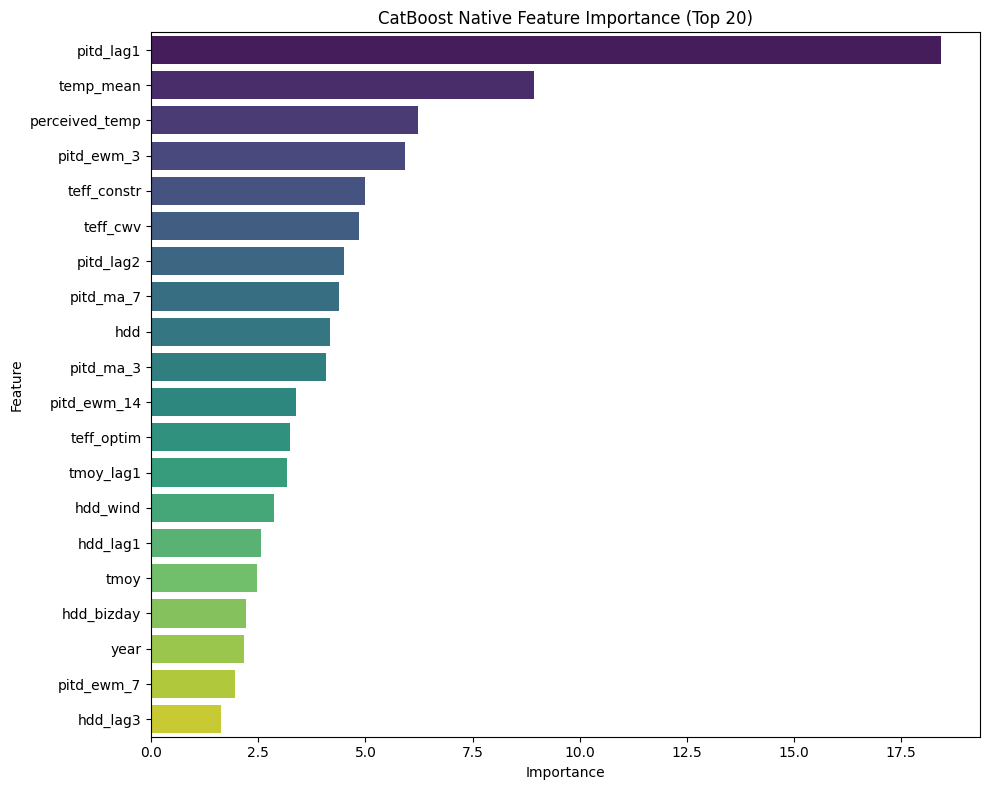


SHAP summaries & waterfall:


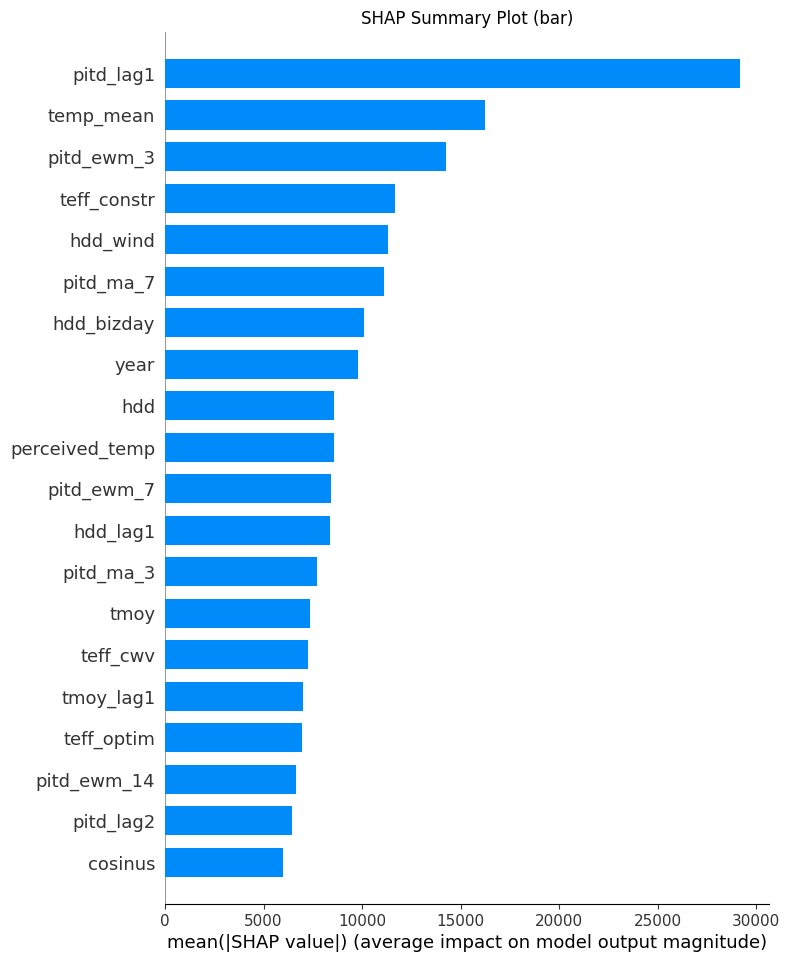

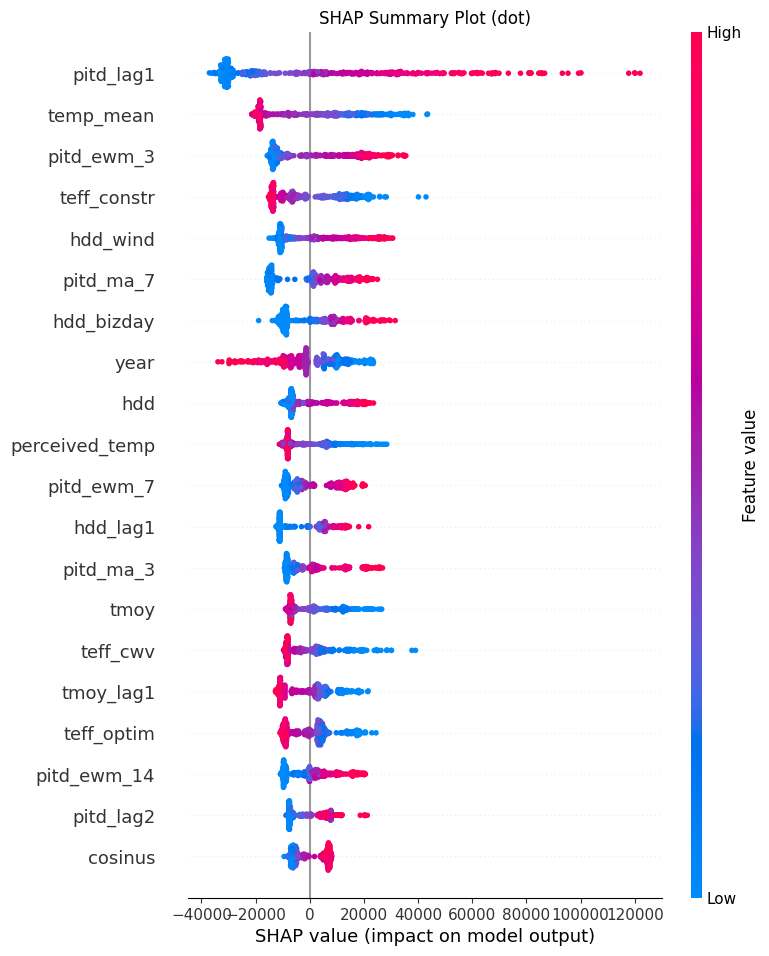

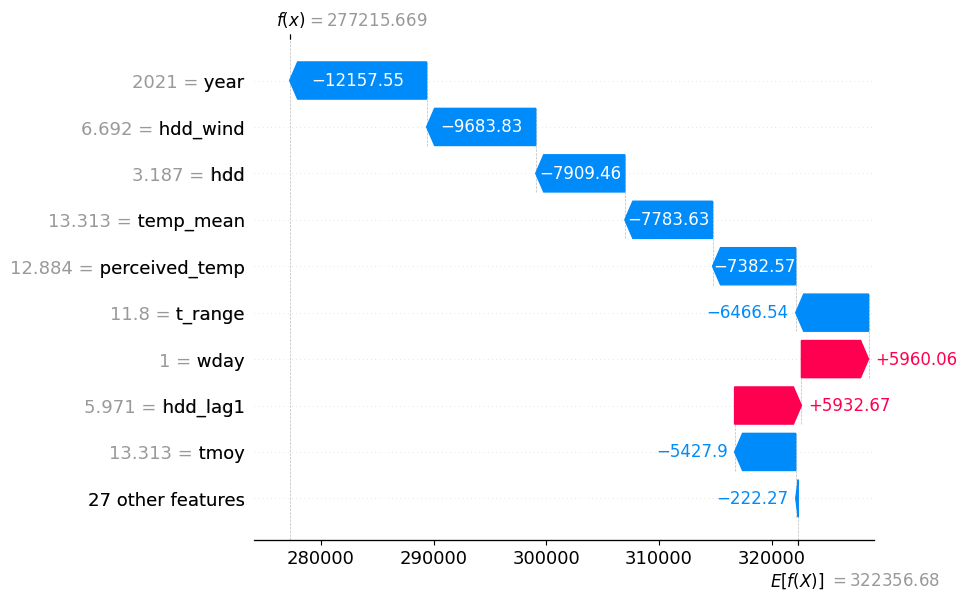

In [ ]:
# Overall Model Comparison

# changer le choix par MAPE, plus interprétable.
# mais quand même afficher le RMSE pour comparer
# dessiner l'arbre. et expliquer les splits. à décrire en mots (dans choix du modèle)   
# table des shap values
# attention au graphique des native feature importance avec la corrélation
# mieux à faire avec celui de sklearn, celui de catboost est différent
# gridsearch sur le nombre de folds k. faire un graphique avec k fold cross validation
# regarder la feature permutation au lieu de feature importance
from catboost import Pool, cv as catboost_cv
import pandas as pd
from utils import (
    plot_native_feature_importance,
    plot_shap_summary,
    plot_shap_waterfall
)



train_pool = Pool(data=X_rfecv, label=y_train, cat_features=cats_rfecv)
comparison_pool = Pool(data=X_rfecv_test, label=y_test, cat_features=cats_rfecv)

# 5-Fold native CatBoost.cv 
N_CV_EVAL_FOLDS = 5
models = {
    #"Default":   default_cb,
    #"TimeAware": time_cb,
    #"Golden":    golden_cb,
    "RS_tuned":  final_model_rs,
    "Optuna":    final_model_optuna_focused
}

model_cv_metrics = {}
for name, model in models.items():
    print(f"Running cv() for '{name}' …")
    raw = model.get_params()
    keep = ['iterations','learning_rate','depth',
            'l2_leaf_reg','border_count',
            'has_time','boosting_type',
            'monotone_constraints']
    params = {k: raw[k] for k in keep if k in raw and raw[k] is not None}
    params.update({'loss_function': 'RMSE','eval_metric':'RMSE','custom_metric':['MAPE','R2']})

    cv_df = catboost_cv(
        pool=train_pool,
        params=params,
        fold_count=N_CV_EVAL_FOLDS,
        partition_random_seed=RANDOM_STATE,
        shuffle=True,
        as_pandas=True,
        verbose=False
    )

    mean_rmse = cv_df['test-RMSE-mean'].iloc[-1]
    mean_mape = cv_df['test-MAPE-mean'].iloc[-1] * 100
    mean_r2   = cv_df['test-R2-mean'].iloc[-1]

    model_cv_metrics[name] = {'RMSE': mean_rmse, 'MAPE': mean_mape, 'R2': mean_r2}
    print(f" {name}: RMSE={mean_rmse:.4f}, MAPE={mean_mape:.2f}%, R²={mean_r2:.4f}\n")

comparison_df = pd.DataFrame(model_cv_metrics).T[['RMSE','MAPE','R2']]
print("Combined Model Performance (Mean CV Scores):")
print(comparison_df.sort_values('RMSE').to_string(float_format="%.4f"))

# Pairwise .compare() on Test Set

names = list(models)
for i in range(len(names)):
    for j in range(i+1, len(names)):
        n1, n2 = names[i], names[j]
        print(f"\nComparing '{n1}' vs '{n2}' …")
        df_cmp = models[n1].compare(models[n2], comparison_pool, metrics=['RMSE'])

df_cmp

best = comparison_df['RMSE'].idxmin()
print(f"\nSelected '{best}' as best model.")
final = models[best]

print("\nNative feature importance:")
plot_native_feature_importance(final, X_rfecv.columns.tolist())

print("\nSHAP summaries & waterfall:")
plot_shap_summary(final, X_rfecv_test, X_rfecv.columns.tolist(), plot_type="bar")
plot_shap_summary(final, X_rfecv_test, X_rfecv.columns.tolist(), plot_type="dot")
plot_shap_waterfall(final, X_rfecv_test, X_rfecv.columns.tolist(), instance_index=1)


HOLIDAYS only →  RMSE: 16630.67,  MAPE: 7.76%,  R²: 0.991


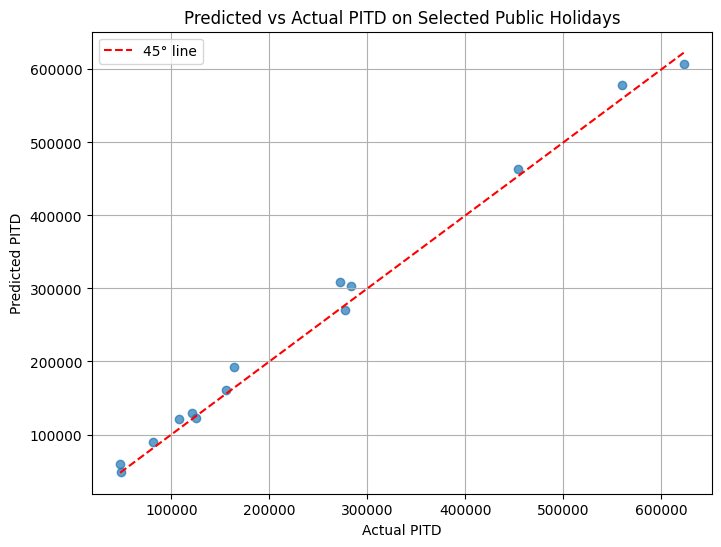

In [ ]:
# comme vous voulez si vous voulez garder ou non

# adjacent et pont publics aussi
X_full_test    = X_test_sel

frholidays = [
    "NewYearsDay",
    "ChristmasDay",
    "EasterMonday",
    "PentecostMonday",
    "FRAscension",
    "LaborDay",
    "FRFetDeLaVictoire1945",
    "FRBastilleDay",
    "FRArmisticeDay",
    "FRAssumptionVirginMary",
    "FRAllSaints"
]

mask = X_full_test['public_holidays'].isin(frholidays)


idx_hol = X_full_test.index[mask]
y_hol    = y_test.loc[   idx_hol ]
X_hol_rf = X_rfecv_test.loc[idx_hol]


yhat_hol = final.predict(X_hol_rf)
rmse_hol = np.sqrt(mean_squared_error(   y_hol, yhat_hol))
mape_hol = mean_absolute_percentage_error(y_hol, yhat_hol) * 100
r2_hol   = r2_score(                        y_hol, yhat_hol)

print(f"HOLIDAYS only →  RMSE: {rmse_hol:.2f},  MAPE: {mape_hol:.2f}%,  R²: {r2_hol:.3f}")

# 5) scatter
plt.figure(figsize=(8,6))
plt.scatter(y_hol, yhat_hol, alpha=0.7)
lims = [min(y_hol.min(), yhat_hol.min()), max(y_hol.max(), yhat_hol.max())]
plt.plot(lims, lims, 'r--', label='45° line')
plt.title('Predicted vs Actual PITD on Selected Public Holidays')
plt.xlabel('Actual PITD')
plt.ylabel('Predicted PITD')
plt.legend()
plt.grid(True)
plt.show()
# %%
